<a href="https://colab.research.google.com/github/ragul-n/LendingClubPredicction/blob/without_text_1/Loan_Grading_without_Text_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
!pip install wordcloud

Downloading data from Kaggle:

* Upload your Kaggle API token (kaggle.json file) below to download data from kaggle.


In [2]:
from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!kaggle datasets download -d wordsforthewise/lending-club

Saving kaggle.json to kaggle.json
 98% 1.24G/1.26G [00:11<00:00, 87.2MB/s]
100% 1.26G/1.26G [00:12<00:00, 113MB/s] 


In [3]:
!unzip lending-club.zip

Archive:  lending-club.zip
  inflating: accepted_2007_to_2018Q4.csv.gz  
  inflating: accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv  
  inflating: rejected_2007_to_2018Q4.csv.gz  
  inflating: rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv  


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display
import time

#Cleaning Dataset

In [3]:

#columns to be used
cols= ["loan_amnt" ,'term' ,'int_rate' , 'installment' ,'grade'  ,'emp_length' ,'home_ownership' ,'annual_inc' , 'dti' ,'verification_status' ,'issue_d' ,'loan_status' ,
            'pymnt_plan'  ,'zip_code' ,'addr_state' ,'dti' ,'fico_range_low' ,'fico_range_high' ,'tax_liens', "open_acc", "pub_rec",
        "revol_bal", "revol_util", "total_acc", "mort_acc", 'application_type']



In [4]:
accepted_loans = pd.read_csv("/content/accepted_2007_to_2018Q4.csv.gz",  low_memory=False, usecols=cols)

accepted_loans.drop(accepted_loans.tail(2).index, 
        inplace = True)

accepted_loans = accepted_loans[accepted_loans['application_type'] =="Individual"]

accepted_loans= accepted_loans[[(not i) for i in accepted_loans['loan_amnt'].isna()]]

In [9]:
data=data.fillna({ "home_ownership":"not known", "emp_length": "not known", "zip_code": "000XX"})
data=data.fillna(data.mean(numeric_only=True))

Distribution of Loan Grades 

Text(0.5, 1.0, 'Loan Grade Distribution')

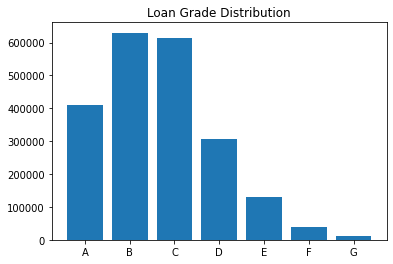

In [11]:
val=dict(accepted_loans.groupby("grade")["grade"].count())

plt.bar( val.keys(),val.values(), width=0.8 )
plt.title("Loan Grade Distribution")

#preparing Data for training

In [12]:
data.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,zip_code,addr_state,dti,fico_range_low,fico_range_high,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,tax_liens
0,3600.0,36 months,13.99,123.03,C,10+ years,MORTGAGE,55000.0,Not Verified,n,190xx,PA,5.91,675.0,679.0,7.0,0.0,2765.0,29.7,13.0,1.0,0.0
1,24700.0,36 months,11.99,820.28,C,10+ years,MORTGAGE,65000.0,Not Verified,n,577xx,SD,16.06,715.0,719.0,22.0,0.0,21470.0,19.2,38.0,4.0,0.0
3,35000.0,60 months,14.85,829.90,C,10+ years,MORTGAGE,110000.0,Source Verified,n,076xx,NJ,17.06,785.0,789.0,13.0,0.0,7802.0,11.6,17.0,1.0,0.0
4,10400.0,60 months,22.45,289.91,F,3 years,MORTGAGE,104433.0,Source Verified,n,174xx,PA,25.37,695.0,699.0,12.0,0.0,21929.0,64.5,35.0,6.0,0.0
5,11950.0,36 months,13.44,405.18,C,4 years,RENT,34000.0,Source Verified,n,300xx,GA,10.20,690.0,694.0,5.0,0.0,8822.0,68.4,6.0,0.0,0.0


Encoding Text Data

In [13]:
data.grade= pd.Categorical(data.grade)
data['grade']= data.grade.cat.codes

data.term= pd.Categorical(data.term)
data['term']= data.term.cat.codes

data.pymnt_plan= pd.Categorical(data.pymnt_plan)
data['pymnt_plan']= data.pymnt_plan.cat.codes

data.emp_length= pd.Categorical(data.emp_length)
data.emp_length= data.emp_length.cat.codes

data.home_ownership= pd.Categorical(data.home_ownership)
data.home_ownership= data.home_ownership.cat.codes

data.verification_status= pd.Categorical(data.verification_status)
data.verification_status= data.verification_status.cat.codes

data.zip_code = pd.Categorical(data.zip_code)
data.zip_code= data.zip_code.cat.codes

data.addr_state= pd.Categorical(data.addr_state)
data.addr_state= data.addr_state.cat.codes

In [14]:
data.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,zip_code,addr_state,dti,fico_range_low,fico_range_high,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,tax_liens
0,3600.0,0,13.99,123.03,2,1,1,55000.0,0,0,183,38,5.91,675.0,679.0,7.0,0.0,2765.0,29.7,13.0,1.0,0.0
1,24700.0,0,11.99,820.28,2,1,1,65000.0,0,0,555,41,16.06,715.0,719.0,22.0,0.0,21470.0,19.2,38.0,4.0,0.0
3,35000.0,1,14.85,829.90,2,1,1,110000.0,1,0,70,31,17.06,785.0,789.0,13.0,0.0,7802.0,11.6,17.0,1.0,0.0
4,10400.0,1,22.45,289.91,5,3,1,104433.0,1,0,167,38,25.37,695.0,699.0,12.0,0.0,21929.0,64.5,35.0,6.0,0.0
5,11950.0,0,13.44,405.18,2,4,5,34000.0,1,0,291,10,10.20,690.0,694.0,5.0,0.0,8822.0,68.4,6.0,0.0,0.0


Creating Training, validation and test set.

* Training Set: 80%
* Validation set: 10%
* Test Set: 10%

In [15]:
from sklearn.model_selection import train_test_split

y= data['grade']
x=data.drop('grade', axis=1)

#Normalizing Data
x=(x-x.mean())/x.std()


x_train, x_test,y_train, y_test= train_test_split(x, y, test_size=0.2, random_state=1)
x_test, x_val,y_test, y_val= train_test_split(x_test, y_test, test_size=0.5, random_state=1)

In [18]:
#Tensorflow Dataset API
training_data= tf.data.Dataset.from_tensor_slices((x_train.values,  y_train.values))
validation_data= tf.data.Dataset.from_tensor_slices((x_val.values, y_val.values))
test_data= tf.data.Dataset.from_tensor_slices((x_test.values,  y_test.values))

#Batching Datasets
training_data= training_data.batch(64)
validation_data=validation_data.batch(64)
test_data= test_data.batch(64)

#Building Model

In [66]:
model= tf.keras.Sequential([
                            tf.keras.layers.Dense(64, activation="relu"),
                            tf.keras.layers.Dense(64, activation="relu"),
                            tf.keras.layers.Dense(64, activation="relu"),
                            tf.keras.layers.Dense(32, activation="relu"), 
                            tf.keras.layers.Dense(16, activation="relu"),
                            tf.keras.layers.Dense(7, activation="softmax"),
                            ])


#Training Model

In [67]:


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               metrics= ["accuracy"]
)

In [68]:
history= model.fit(training_data, validation_data=validation_data, epochs=30, shuffle=True)

Epoch 1/30
26750/26750 [==============================] - 60s 2ms/step - loss: 0.3424 - accuracy: 0.8479 - val_loss: 0.3046 - val_accuracy: 0.8641
Epoch 2/30
26750/26750 [==============================] - 60s 2ms/step - loss: 0.2965 - accuracy: 0.8663 - val_loss: 0.2789 - val_accuracy: 0.8715
Epoch 3/30
26750/26750 [==============================] - 60s 2ms/step - loss: 0.2728 - accuracy: 0.8745 - val_loss: 0.2736 - val_accuracy: 0.8711
Epoch 4/30
26750/26750 [==============================] - 60s 2ms/step - loss: 0.2638 - accuracy: 0.8784 - val_loss: 0.2631 - val_accuracy: 0.8775
Epoch 5/30
26750/26750 [==============================] - 60s 2ms/step - loss: 0.2564 - accuracy: 0.8821 - val_loss: 0.2472 - val_accuracy: 0.8875
Epoch 6/30
26750/26750 [==============================] - 60s 2ms/step - loss: 0.2499 - accuracy: 0.8853 - val_loss: 0.2416 - val_accuracy: 0.8896
Epoch 7/30
26750/26750 [==============================] - 60s 2ms/step - loss: 0.2447 - accuracy: 0.8877 - val_loss: 0

In [83]:
metrics=model.evaluate(test_data, return_dict=True)

print("Accuracy: %.2f"%(metrics["accuracy"]*100) +"%" )
print("Loss:%.2f"%(metrics["loss"]) + "%" )

3344/3344 [==============================] - 6s 2ms/step - loss: 0.1813 - accuracy: 0.9174
Accuracy: 91.74%
Loss:0.18%


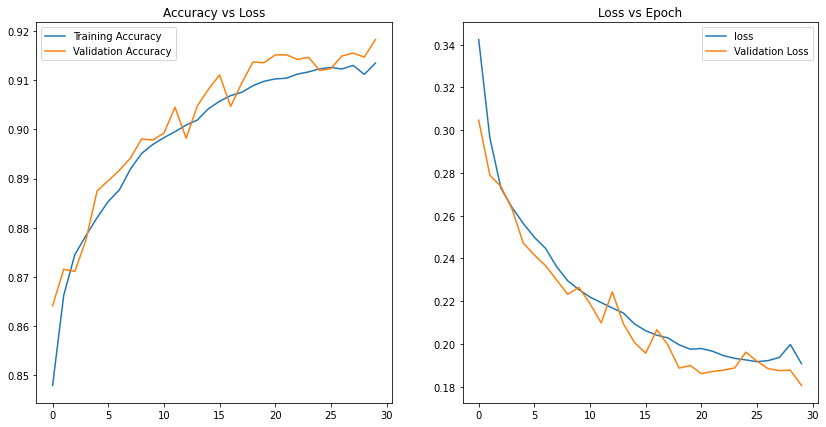

In [90]:
fig, [accuracy, loss]= plt.subplots(ncols=2, figsize=(14,7))

accuracy.plot(history.history["accuracy"], label="Training Accuracy")
accuracy.plot(history.history["val_accuracy" ],  label= "Validation Accuracy")
accuracy.legend()
accuracy.set_title("Accuracy vs Loss")

loss.plot(history.history["loss"], label="loss")
loss.plot(history.history["val_loss"], label="Validation Loss")
loss.legend()
loss.set_title("Loss vs Epoch")
plt.show()

In [84]:
model.save("model.h5")